In [15]:
"""
imports and music loading

"""

import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal
import IPython.display as ipd
import librosa
from keras import models

from optimization_content_extraction import getIterateFunction, gradientDescent,SGD_Nesterov,Adam,getIterateFunctionStyle
from griffin2 import audio_utilities

pathToModel = "model_model20181211222107.h5"
sampleAu,fs = librosa.load("/home/clementp/INNO/genres/pop/pop.00001.au")
#sampleAu,fs = librosa.load("/home/clementp/INNO/gtzan_final/src/griffin2/bkvhi2.wav")
#sampleAu,fs = librosa.load("/home/clementp/INNO/Mylene.wav")



In [18]:
"""
split the music in about 20 subsongs of size 3 seconds and apply fft to it or stft

"""

X=sampleAu[:]

window=0.1
overlap=0.5
xshape = X.shape[0]
chunk = int(xshape*window)
offset = int(chunk*(1.-overlap))
spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
x=spsong[0]

librosa.output.write_wav("/home/clementp/INNO/Pop_avant_griffin.wav",x,fs)
fft=audio_utilities.stft_for_reconstruction(x, 1024, 1024//4)
module=(abs(fft).T)[:128,:,np.newaxis]
#module=((abs(signal.stft(x, fs=fs, nperseg=512)[2])**2)*2500)[:128,:259,np.newaxis]
#module=((abs(signal.stft(x, fs=fs, nperseg=512,noverlap=512//4*3)[2])**2)*2500)[:,:,np.newaxis]
n,l,p=module.shape
module_debut=np.concatenate((module[:,:255,:],np.zeros((n,4,p))),axis=1)
if(l>=518):
    module_fin=module[:,259:318,:]
else:
    module_fin=np.concatenate((module[:,259:,:],np.zeros((n,518-l,p))),axis=1)
phase=np.angle(fft.T)

#phase=np.angle(signal.stft(x, fs=fs, nperseg=512,noverlap=512//4*3)[2])
Image_aux_debut=np.squeeze(np.stack([module_debut,module_debut,module_debut], axis=-1))
Image_debut=Image_aux_debut[np.newaxis,:,:,:]
Image_aux_fin=np.squeeze(np.stack([module_fin,module_fin,module_fin], axis=-1))
Image_fin=Image_aux_fin[np.newaxis,:,:,:]

ipd.Audio(x,rate=fs)

In [4]:
"""
just to visualize a bit the effect of the different transformation fft and stft
"""

module1=((abs(signal.stft(x, nperseg=512,noverlap=512//2)[2])**2)*2500)[:,:,np.newaxis]
module2=abs(audio_utilities.stft_for_reconstruction(x[:], 512, 512//4)).T[:128,:,np.newaxis]
print(module1.shape)
print(module2.shape)
Image_aux1=np.squeeze(np.stack([module1,module1,module1], axis=-1))
Image_aux2=np.squeeze(np.stack([module2,module2,module2], axis=-1))

(257, 260, 1)
(128, 513, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


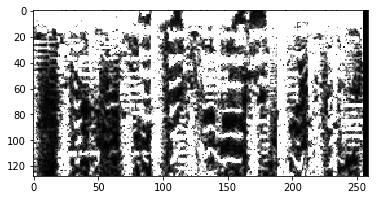

In [5]:
plt.imshow(Image_aux_debut)

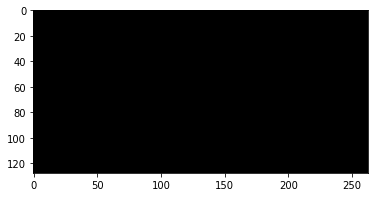

In [6]:
plt.imshow(Image_aux_fin)

In [19]:
"""
load the genre classifier model and the dict associated
"""

model= models.load_model(pathToModel)
inputImage=model.input
layerDict=dict([(layer.name, layer) for layer in model.layers])

In [32]:
"""
get the fonction which calculates loss and grads from inputImage
"""
Image=Image_debut
iterate_style = getIterateFunctionStyle(model,layerDict,"block1_conv1",inputImage,Image,1.5,0.5,0.1,6)
#iterate = getIterateFunction(model,layerDict,"block1_conv1",inputImage,Image)

max target 47.639145
Tensor("strided_slice_4:0", shape=(128, 259, 64), dtype=float32)
Tensor("Const_8:0", shape=(128, 259, 64), dtype=float32)
(128, 259, 64)
(128, 259, 64)


(1, 128, 259, 3)


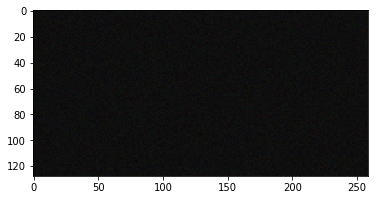

In [33]:
"""
random noise which is about to be transformed
"""

Noise_aux=np.random.randint(10,size=Image.shape)+10
plt.imshow(np.squeeze(Noise_aux))
Noise=np.array(Noise_aux,dtype=object)
print(Noise.shape)

In [ ]:
##first attempt
lr=100
lossValue = gradientDescent(iterate,Noise, lr)


In [17]:
##Nesterov momentum
lr0=1
momentum=0.9
early_stopping=1024
lossValue = SGD_Nesterov(iterate,Noise,lr0,momentum,early_stopping)

1 107479310.0 5929.5703125 5929.5703
2 278801020000.0 509518.05463867186 512906.6
3 3224803700000000.0 58848343.31979492 59292576.0
4 4.3079195e+19 7316213758.824257 7366038000.0
5 6.2226784e+23 810470610945.0582 817055200000.0
6 9.4771756e+27 108833329900133.45 109562750000000.0
7 1.4998539e+32 1.2247032626051544e+16 1.2344983e+16
8 2.4439545e+36 1.6681133456690888e+18 1.6791357e+18
9 inf 1.9027963267712215e+20 1.9178093e+20
10 inf 2.6224906444762675e+22 2.6396158e+22
11 inf 3.032323830320842e+24 3.0559262e+24
12 inf 4.218849627236413e+26 4.2461405e+26
13 inf 4.935545036173029e+28 4.9735147e+28
14 inf 6.922989524414352e+30 6.9674094e+30
15 inf 8.180444890597192e+32 8.242752e+32
16 inf 1.1553760496589597e+35 1.16273845e+35
17 inf 1.3768498525453712e+37 1.3872482e+37
18 inf inf inf
19 nan nan nan


/home/clementp/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [34]:
##Adam
lr0=2
early_stopping=0
factor=0.95
epochs=20
niter=300
lossValue = Adam(iterate_style,Noise,lr0,early_stopping,factor,epochs,niter)

1 94.81863 1.9999990385930697
42.1601 19.509243 218.2385
2 87.651764 2.002710622979924
43.46287 2.7516758 210.81616
3 118.78371 2.006960083256996
48.576046 50.20586 208.16713
4 112.15017 2.0129950009416087
54.170597 20.586151 206.01198
5 109.492516 1.9871538604635306
59.437687 0.023489868 203.24243
6 114.95576 1.9389780535623453
63.347702 0.00011838183 199.34142
7 117.63102 1.9138816663528238
65.460785 2.8133789e-05 194.39828
8 117.57257 1.895038954336172
65.80966 4.8280926e-05 188.58055
9 115.19127 1.8509874410083544
64.655075 6.377901e-05 182.08629
10 111.030975 1.857940045992104
62.3463 0.00011277835 175.1147
11 105.64195 1.857372756898361
59.238075 1.3589952e-05 167.84827
12 99.516174 1.8319677377044181
55.64767 0.0004042608 160.44472
13 93.061935 1.809852384901925
51.834595 0.01362667 153.03227
14 86.57034 1.784084953176566
47.998863 0.0016962363 145.71208
15 80.287575 1.7272918525510819
44.279694 0.024153756 138.55959
16 74.31802 1.6707110863496522
40.77006 4.899622e-05 131.62912

In [33]:
"""
tool to visualize the module created from noise
"""

def etale(x,moyenne):
    if(x>moyenne):
        return((np.tanh(2*(x-moyenne)/(255-moyenne))+1)/2*255)
    else:
        return(x)

128 259 3
16.991871796976707
0.23167593895920569


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


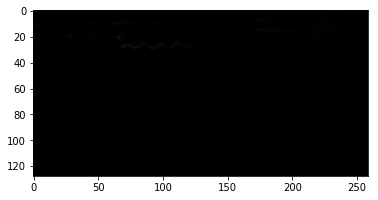

In [35]:
"""
process of Noise to see how it looks like 
"""

Noise=np.squeeze(Noise)
n,l,p=Noise.shape
print(n,l,p)
maximum=np.max(Noise)
print(maximum)
moyenne=np.mean(Noise)
print(moyenne)

for i in range(n):
    for j in range(l):
        m=np.mean(Noise[i,j,:])
        for k in range(p):
            #Noise[i,j,k]=int(etale(m,moyenne))
            Noise[i,j,k]=int(m)
Noise=np.array(Noise,dtype=int)
plt.imshow(Noise)

In [88]:
"""
get a song from the stft/fft module just by using the reference phase
"""

softmax = lambda x:max(x,0)
softmax=np.vectorize(softmax)
Noise=softmax(Noise)
print(Noise.shape)
module=np.sqrt(np.squeeze(Noise[:,:,0])/2500)


def reverse_keeping_phase(module):
    print(phase.shape)
    print(module.shape)
    absolue=np.zeros(phase.shape)
    n,l=module.shape
    for i in range(n):
        for j in range(l):
            absolue[i,j]=module[i,j]
    new_x=absolue*(np.cos(phase)+np.sin(phase)*1j)
    return(signal.istft(new_x,fs=fs,nperseg=512))



(128, 259, 3)


In [16]:
"""
get a song from the stft/fft module by using griffin lim algorithm
"""


from griffin.utils import audio
from griffin.hparams import hparams
from griffin.griffin_lim import inv_spectrogram, tf
import os

#absolue=np.zeros(phase.shape)
def reverse_griffin(module):
    absolue=np.zeros(phase.shape)
    print(phase.shape)
    print(module.shape)
    n,l=module.shape
    for i in range(n):
        for j in range(l):
            absolue[i,j]=module[i,j]
    plt.imshow(absolue)
    spectrogram=audio.semi_spectrogram(absolue)
    attempt=audio.inv_spectrogram(spectrogram)
    audio.save_wav(attempt,"/home/clementp/INNO/gtzan_final/src/pop_transformed.wav")
    print("done")



In [8]:
"""
get a song from the stft/fft module by using griffin lim algorithm (a better one)
"""

fft_size=1024
hopsamp=fft_size//4
iterations=300
sample_rate_hz=fs

def reverse_griffin2(module):
    n2,l2=phase.shape
    #absolue=np.zeros((max(n2,l2),max(n2,l2)))
    absolue=np.zeros(phase.shape)
    print(phase.shape)
    print(module.shape)
    n,l=module.shape
    for i in range(n):
        for j in range(min(l,l2)):
            absolue[i,j]=module[i,j]
    
    plt.imshow(absolue)
    absolue=absolue.T
    print(absolue.shape)
    x_reconstruct = audio_utilities.reconstruct_signal_griffin_lim(absolue,fft_size, hopsamp,iterations)
    max_sample = np.max(abs(x_reconstruct))
    if max_sample > 1.0:
        x_reconstruct = x_reconstruct / max_sample
    # Save the reconstructed signal to a WAV file.
    plt.plot([i for i in range(len(x_reconstruct))],x_reconstruct)
    print(x_reconstruct)
    audio_utilities.save_audio_to_file(x_reconstruct,sample_rate_hz)
    print("done")
    print(max_sample)
    ipd.Audio(x_reconstruct,rate=fs)
    



(513, 255)
(128, 259)
(255, 513)
Reconstruction iteration: 1/300 RMSE: 1.0021412829043204 
Reconstruction iteration: 2/300 RMSE: 0.08998155943175096 
Reconstruction iteration: 3/300 RMSE: 0.0554652328160799 
Reconstruction iteration: 4/300 RMSE: 0.04101366585816908 
Reconstruction iteration: 5/300 RMSE: 0.03317724351241593 
Reconstruction iteration: 6/300 RMSE: 0.027673595859648466 
Reconstruction iteration: 7/300 RMSE: 0.0244342045923032 
Reconstruction iteration: 8/300 RMSE: 0.02247462469267745 
Reconstruction iteration: 9/300 RMSE: 0.020238395701439843 
Reconstruction iteration: 10/300 RMSE: 0.018244504542215084 
Reconstruction iteration: 11/300 RMSE: 0.016698825447285202 
Reconstruction iteration: 12/300 RMSE: 0.015639376584023035 
Reconstruction iteration: 13/300 RMSE: 0.014963668593042465 
Reconstruction iteration: 14/300 RMSE: 0.014389102395201655 
Reconstruction iteration: 15/300 RMSE: 0.013747591544464118 
Reconstruction iteration: 16/300 RMSE: 0.013054560452495282 
Reconstruc

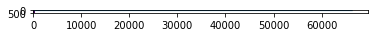

In [19]:
#module=np.sqrt(np.squeeze(Image_aux[:,:,0])/2500)
#module=np.concatenate((np.squeeze(Image_aux_debut[:,:,0]),np.squeeze(module_fin)),axis=1)
#print(Noise.shape)
#print(module_fin.shape)
#module=np.squeeze(Noise[:,:255,0])
module=np.squeeze(module_debut[:,:,0])
reverse_griffin2(module)

(256, 128)
Reconstruction iteration: 1/300 RMSE: 0.9454114781597005 
Reconstruction iteration: 2/300 RMSE: 0.06620652190236147 
Reconstruction iteration: 3/300 RMSE: 0.040345846647712943 
Reconstruction iteration: 4/300 RMSE: 0.03159894399076943 
Reconstruction iteration: 5/300 RMSE: 0.02707285700646264 
Reconstruction iteration: 6/300 RMSE: 0.02284488543209992 
Reconstruction iteration: 7/300 RMSE: 0.01992190227912083 
Reconstruction iteration: 8/300 RMSE: 0.017158623590005133 
Reconstruction iteration: 9/300 RMSE: 0.016979204051026067 
Reconstruction iteration: 10/300 RMSE: 0.013453984949331903 
Reconstruction iteration: 11/300 RMSE: 0.011974615574014748 
Reconstruction iteration: 12/300 RMSE: 0.01097212546535366 
Reconstruction iteration: 13/300 RMSE: 0.010213912509124295 
Reconstruction iteration: 14/300 RMSE: 0.0095725892496003 
Reconstruction iteration: 15/300 RMSE: 0.008996131604084565 
Reconstruction iteration: 16/300 RMSE: 0.008442990631012667 
Reconstruction iteration: 17/300

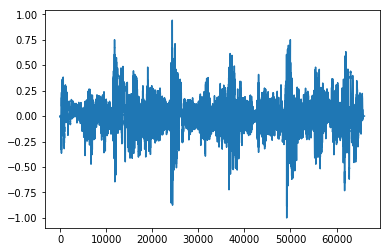

In [59]:
"""
try pooling
"""

#module=np.sqrt(np.squeeze(Image_aux[:,:,0])/2500)
import skimage.measure

def inverse_pooling(module):
    n,l=module.shape
    reverse=np.zeros((2*n,2*l+1))
    for i in range(n):
        for j in range(l):
            reverse[2*i,2*j]=module[i,j]
            reverse[2*i+1,2*j]=module[i,j]
            reverse[2*i,2*j+1]=module[i,j]
            reverse[2*i+1,2*j+1]=module[i,j]
    return(reverse)

fft_size=512
hopsamp=fft_size//4
iterations=300
sample_rate_hz=fs
module=abs(audio_utilities.stft_for_reconstruction(x[:], fft_size, hopsamp))
module=module[:512,:256]
module=skimage.measure.block_reduce(module, (2,2), np.mean)
print(module.shape)
#module=np.squeeze(module1).T
module=inverse_pooling(module)
x_reconstruct = audio_utilities.reconstruct_signal_griffin_lim(module,fft_size, hopsamp,iterations)
max_sample = np.max(abs(x_reconstruct))
if max_sample > 1.0:
    x_reconstruct = x_reconstruct / max_sample
# Save the reconstructed signal to a WAV file.
plt.plot([i for i in range(len(x_reconstruct))],x_reconstruct)
print(x_reconstruct)
audio_utilities.save_audio_to_file(x_reconstruct,sample_rate_hz)
print(max_sample)
ipd.Audio(x_reconstruct,rate=fs)
#reverse_griffin2(module)

Reconstruction iteration: 1/300 RMSE: 0.9915126354359449 
Reconstruction iteration: 2/300 RMSE: 0.07807943829732632 
Reconstruction iteration: 3/300 RMSE: 0.048674033982389064 
Reconstruction iteration: 4/300 RMSE: 0.03430668759505613 
Reconstruction iteration: 5/300 RMSE: 0.027399775577220405 
Reconstruction iteration: 6/300 RMSE: 0.023108804659758155 
Reconstruction iteration: 7/300 RMSE: 0.02009902174990151 
Reconstruction iteration: 8/300 RMSE: 0.018497288424871635 
Reconstruction iteration: 9/300 RMSE: 0.01769667551605198 
Reconstruction iteration: 10/300 RMSE: 0.01659932994096048 
Reconstruction iteration: 11/300 RMSE: 0.01603953570080863 
Reconstruction iteration: 12/300 RMSE: 0.017364437468660152 
Reconstruction iteration: 13/300 RMSE: 0.014236729910581471 
Reconstruction iteration: 14/300 RMSE: 0.01306539379677793 
Reconstruction iteration: 15/300 RMSE: 0.012326853409501286 
Reconstruction iteration: 16/300 RMSE: 0.011647356992419181 
Reconstruction iteration: 17/300 RMSE: 0.0

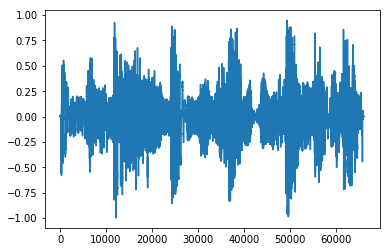

In [75]:
"""
on peut supprimer les hautes fréquances

"""
fft_size=512
hopsamp=fft_size//4
iterations=300
sample_rate_hz=fs
module=abs(audio_utilities.stft_for_reconstruction(x[:], fft_size, hopsamp)).T
n,l=module.shape
for i in range(128,n):
    for j in range(l):
        module[i,j]=0
x_reconstruct = audio_utilities.reconstruct_signal_griffin_lim(module.T,fft_size, hopsamp,iterations)
max_sample = np.max(abs(x_reconstruct))
if max_sample > 1.0:
    x_reconstruct = x_reconstruct / max_sample
# Save the reconstructed signal to a WAV file.
plt.plot([i for i in range(len(x_reconstruct))],x_reconstruct)
print(x_reconstruct)
audio_utilities.save_audio_to_file(x_reconstruct,sample_rate_hz)
print(max_sample)
ipd.Audio(x_reconstruct,rate=fs)
#reverse_griffin2(module)

In [122]:

t,x=reverse_keeping_phase(module)
print(x.shape)
ipd.Audio(x,rate=fs)

(257, 285)
(128, 259)
(72704,)
